<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# OrthoIV and DRIV: Use Cases and Examples

OrthoIV, DMLIV, and DRIV are a suite of algorithms that use Double Machine Learning approach and Doubly Robust machine learning approach to estimate the heterogeneous treatment effect with an endogeneous treatment and an instrument.

The EconML SDK implements the following  classes:

* **OrthoIV classes**: solve the moment equation $E[(Y-E[Y|X]-\theta(X) \cdot (T-E[T|X]))(Z-E[Z|X])] = 0$
* **DMLIV classes**: minimize the square loss   $E[(Y- E[Y|X] - \theta(X) \cdot (E[T|X, Z] - E[T|X]))^2]$
* **DRIV classes**: minimize the square loss
$$E[(\theta_{pre}(X) + \frac{(Y- E[Y|X]-\theta_{pre}(X) \cdot (T- E[T|X]))(Z-E[Z|X])}{E[T\cdot Z|X]-E[T|X] \cdot E[Z|X] }-\theta(X))^2]$$
* **Intent to Treat DRIV classes**: a special case of DRIV where the instrument is the assignment in a randomized controlled trail with non-compliance




In ths notebook, we show the performance of OrthoIV and DRIV on estimating average treatment effect and heterogeneous treatment effect.

**Notebook contents:**

1. [Example Usage with Average Treatment Effects](#Example-Usage-with-Average-Treatment-Effects)
2. [Example Usage with Heterogeneous Treatment Effects](#Example-Usage-with-Heterogeneous-Treatment-Effects)

In [2]:
# Helper imports
import numpy as np
from scipy import special
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

# Example Usage with Average Treatment Effects

## DGP
We construct the DGP as below. The instrument corresponds to a fully randomized recommendation of treatment. Then each sample complies with the recommendation to some degree. This probability depends on both the observed feature $X$ and an unobserved confounder that has a direct effect on the outcome.

\begin{align}
W \sim \; & \text{Normal}(0,\, I_{n_w})   \tag{Observed confounders}\\
Z \sim \; & \text{Bernoulli}(p=0.5)   \tag{Instrument}\\
\nu \sim \; & \text{U}[0, 5] \tag{Unobserved confounder}\\
C \sim \; & \text{Bernoulli}(p=0.8 \cdot \text{Sigmoid}(0.4 \cdot X[0] + \nu))   \tag{Compliers when recommended}\\
C0 \sim \; & \text{Bernoulli}(p=0.006)   \tag{Non-Compliers when not recommended}\\
T = \; & C \cdot Z + C0 \cdot (1-Z)  \tag{Treatment}\\
y \sim \; & \theta \cdot T + 2 \cdot \nu + 5 \cdot (X[3]>0) + 0.1 \cdot \text{U}[0, 1]  \tag{Outcome}
\end{align}

Moreover, the constant treatment effect is presdefined here, that's what we want to learn from the model.
\begin{align}
\theta = \; & 10 \tag{ATE}\\
\end{align}

In [3]:
# test performance
def dgp(n, p, true_fn):
    X = np.random.normal(0, 1, size=(n, p))
    Z = np.random.binomial(1, 0.5, size=(n,))
    nu = np.random.uniform(0, 5, size=(n,))
    coef_Z = 0.8
    C = np.random.binomial(
        1, coef_Z * special.expit(0.4 * X[:, 0] + nu)
    )  # Compliers when recomended
    C0 = np.random.binomial(
        1, 0.006 * np.ones(X.shape[0])
    )  # Non-compliers when not recommended
    T = C * Z + C0 * (1 - Z)
    y = (
        true_fn(X) * T
        + 2 * nu
        + 5 * (X[:, 3] > 0)
        + 0.1 * np.random.uniform(0, 1, size=(n,))
    )
    return y, T, Z, X

<IPython.core.display.Javascript object>

In [4]:
func = lambda X: 10
n = 5000
p = 10
y, T, Z, X = dgp(n, p, func)

<IPython.core.display.Javascript object>

## Train Estimators
We train multiple estimators from OrthoIV and DRIV classes, and see whether they could all recover the true estimate
### OrthoIV Estimator

In [5]:
model = lambda: LinearRegression()
model_clf = lambda: LogisticRegression()

<IPython.core.display.Javascript object>

In [6]:
from econml.iv.dml import OrthoIV

est1 = OrthoIV(projection=False, discrete_treatment=True, discrete_instrument=True)
est1.fit(y, T, Z=Z, X=None, W=X)
print("True Treatment Effect: ", func(X))
est1.summary(alpha=0.05)

True Treatment Effect:  10
Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,10.04,0.138,72.517,0.0,9.768,10.311


<IPython.core.display.Javascript object>

### Projected OrthoIV Estimator

In [7]:
est2 = OrthoIV(projection=True, discrete_treatment=True, discrete_instrument=True)
est2.fit(y, T, Z=Z, X=None, W=X)
print("True Treatment Effect: ", func(X))
est2.summary(alpha=0.05)

True Treatment Effect:  10
Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,10.026,0.138,72.874,0.0,9.756,10.295


<IPython.core.display.Javascript object>

### DMLIV Estimator

In [8]:
from econml.iv.dml import DMLIV, NonParamDMLIV

est3 = DMLIV(discrete_treatment=True, discrete_instrument=True)
est3.fit(y, T, Z=Z, X=None, W=X)
print("True Treatment Effect: ", func(X))
est3.summary()

True Treatment Effect:  10
Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate
cate_intercept,10.232


<IPython.core.display.Javascript object>

### Linear DRIV Estimator

In [9]:
from econml.iv.dr import LinearDRIV, SparseLinearDRIV, ForestDRIV

est4 = LinearDRIV(discrete_instrument=True, discrete_treatment=True)
est4.fit(y, T, Z=Z, X=None, W=X)
print("True Treatment Effect: ", func(X))
est4.summary()

True Treatment Effect:  10
Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,10.034,0.139,72.211,0.0,9.762,10.306


<IPython.core.display.Javascript object>

### Linear Intent-to-Treat DRIV Estimator

In [10]:
from econml.iv.dr import LinearIntentToTreatDRIV

est5 = LinearIntentToTreatDRIV(model_t_xwz=model_clf())
est5.fit(y, T, Z=Z, X=None, W=X)
print("True Treatment Effect: ", func(X))
est5.summary()

True Treatment Effect:  10
Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,10.03,0.14,71.638,0.0,9.755,10.304


<IPython.core.display.Javascript object>

# Example Usage with Heterogeneous Treatment Effects

## DGP
In this section, we keep the same data generation process, but only change the treatment effect $\theta(X)$ to a function of $X$, and learn the heterogeneous treatment effect. We'd like to see the effect interval learnt from each model could recover the true estimate and the coefficient estimates in the final linear model could recover the true coefficient.

The true effect function is as below:
\begin{align}
\theta = \; & 10 \cdot X[0] \tag{CATE}\\
\end{align}

In [11]:
func = lambda X: 10 * X[:, 0]

<IPython.core.display.Javascript object>

In [12]:
n = 5000
p = 10
y, T, Z, X = dgp(n, p, func)
# Generate test data
X_test = np.linspace(-2, 2, 100).reshape(-1, 1)

<IPython.core.display.Javascript object>

In [13]:
# save output for visualization
res_pred = []
res_lb = []
res_ub = []
name_list = [
    "OrthoIV",
    "ProjectedOrthoIV",
    "NonParamDMLIV",
    "LinearDRIV",
    "ForestDRIV",
    "LinearIntentToTreatDRIV",
]

<IPython.core.display.Javascript object>

## Train Estimators
### OrthoIV Estimator

In [14]:
est1 = OrthoIV(projection=False, discrete_treatment=True, discrete_instrument=True)
est1.fit(y, T, Z=Z, X=X[:, :1], W=X[:, 1:])
print("True Treatment Effect: 10")
est1.summary()

True Treatment Effect: 10


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,10.043,0.142,70.962,0.0,9.765,10.32
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,0.245,0.137,1.793,0.073,-0.023,0.513


<IPython.core.display.Javascript object>

In [15]:
te_pred1 = est1.effect(X_test)
te_pred1_lb, te_pred1_ub = est1.effect_interval(X_test, alpha=0.05)
res_pred.append(te_pred1)
res_lb.append(te_pred1_lb)
res_ub.append(te_pred1_ub)

<IPython.core.display.Javascript object>

### Projected OrthoIV Estimator

In [16]:
est2 = OrthoIV(projection=True, discrete_treatment=True, discrete_instrument=True)
est2.fit(y, T, Z=Z, X=X[:, :1], W=X[:, 1:])
print("True Treatment Effect: 10")
est2.summary()

True Treatment Effect: 10


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,10.052,0.142,70.695,0.0,9.773,10.33
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,0.22,0.137,1.604,0.109,-0.049,0.488


<IPython.core.display.Javascript object>

In [17]:
te_pred2 = est2.effect(X_test)
te_pred2_lb, te_pred2_ub = est2.effect_interval(X_test, alpha=0.05)
res_pred.append(te_pred2)
res_lb.append(te_pred2_lb)
res_ub.append(te_pred2_ub)

<IPython.core.display.Javascript object>

### Non-Parametric DMLIV Estimator

In [18]:
est3 = NonParamDMLIV(
    model_final=RandomForestRegressor(),
    discrete_treatment=True,
    discrete_instrument=True,
)
est3.fit(y, T, Z=Z, X=X[:, :1], W=X[:, 1:])

<IPython.core.display.Javascript object>

In [19]:
te_pred3 = est3.effect(X_test)
res_pred.append(te_pred2)
res_lb.append(np.array([]))
res_ub.append(np.array([]))

<IPython.core.display.Javascript object>

### Linear DRIV Estimator

In [20]:
est4 = LinearDRIV(discrete_instrument=True, discrete_treatment=True)
est4.fit(y, T, Z=Z, X=X[:, :1], W=X[:, 1:])
print("True Treatment Effect: 10")
est4.summary()

True Treatment Effect: 10


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,10.058,0.141,71.339,0.0,9.781,10.334
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,0.245,0.137,1.791,0.073,-0.023,0.513


<IPython.core.display.Javascript object>

In [21]:
te_pred4 = est4.effect(X_test)
te_pred4_lb, te_pred4_ub = est4.effect_interval(X_test, alpha=0.05)
res_pred.append(te_pred4)
res_lb.append(te_pred4_lb)
res_ub.append(te_pred4_ub)

<IPython.core.display.Javascript object>

### Forest DRIV Estimator

In [22]:
est5 = ForestDRIV(discrete_instrument=True, discrete_treatment=True)
est5.fit(y, T, Z=Z, X=X[:, :1], W=X[:, 1:])

<IPython.core.display.Javascript object>

In [23]:
te_pred5 = est5.effect(X_test)
te_pred5_lb, te_pred5_ub = est5.effect_interval(X_test, alpha=0.05)
res_pred.append(te_pred5)
res_lb.append(te_pred5_lb)
res_ub.append(te_pred5_ub)

<IPython.core.display.Javascript object>

### Linear Intent-to-Treat DRIV Estimator

In [24]:
est6 = LinearIntentToTreatDRIV()
est6.fit(y, T, Z=Z, X=X[:, :1], W=X[:, 1:])
print("True Treatment Effect: 10")
est6.summary()

True Treatment Effect: 10


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,9.894,0.162,61.058,0.0,9.577,10.212
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,0.267,0.155,1.728,0.084,-0.036,0.57


<IPython.core.display.Javascript object>

In [25]:
te_pred6 = est6.effect(X_test)
te_pred6_lb, te_pred6_ub = est6.effect_interval(X_test, alpha=0.05)
res_pred.append(te_pred6)
res_lb.append(te_pred6_lb)
res_ub.append(te_pred6_ub)

<IPython.core.display.Javascript object>

##  Performance Visualization

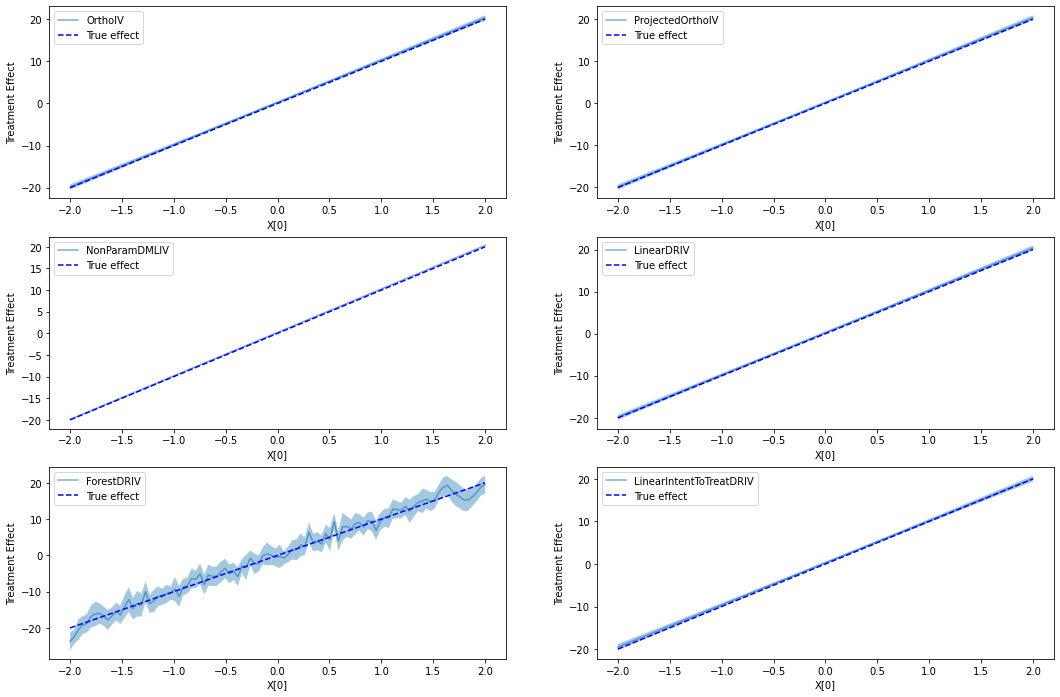

<IPython.core.display.Javascript object>

In [26]:
plt.figure(figsize=(18, 12))
for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.plot(X_test[:, 0], res_pred[i], label=name_list[i], alpha=0.6)
    if res_lb[i].size != 0:
        plt.fill_between(X_test[:, 0], res_lb[i], res_ub[i], alpha=0.4)
    plt.plot(X_test[:, 0], func(X_test), "b--", label="True effect")
    plt.xlabel("X[0]")
    plt.ylabel("Treatment Effect")
    plt.legend()
plt.show()